<a href="https://colab.research.google.com/github/raghavendra-gunnai/EVA4/blob/master/Session12_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchsummary
!pip install torchvision
!pip install albumentations==0.4.5
!pip install torch-lr-finder
!pip install torch-lr-finder -v --global-option="amp"
!pip install tqdm


/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-1xz8r7fl
Created temporary directory: /tmp/pip-req-tracker-ghhhggya
Created requirements tracker '/tmp/pip-req-tracker-ghhhggya'
Created temporary directory: /tmp/pip-install-9pqf1dsa
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-ghhhggya'


In [0]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from albumentations.pytorch.transforms import ToTensor

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/EVA4/s12')
!ls '/content/drive/My Drive/EVA4/s12'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
dogs.json	   __pycache__		      tiny_imagenet.py
lr_finder_s12.py   resnet18_arch.py	      train_test_s12.py
lrfinder_utils.py  resnet18.py		      train_test_utils.py
lr_rangefinder.py  tiny_dataloader.py
lr_utils.py	   tiny_imagenet_download.py


In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kmeans_dogs.json to kmeans_dogs.json
User uploaded file "kmeans_dogs.json" with length 31795 bytes


In [22]:
import pandas as pd
import json

f = open('dogs.json',) 
data = json.load(f)
data.keys()

data['_via_img_metadata'].keys()


dict_keys(['5b6cd4e739d95d260290c3578a86b7cf.jpg15904', '55_1400x.jpg52814', '71bSvPgSGHL._AC_SX425_.jpg24027', '084e211d9d2616da4b8856ee0ab1048c.jpg29100', '220px-PomeranianJPG.jpg16552', '445_Yorkie_Female_10310_087_sharper_2.jpg22011', '3950DDC100000578-0-image-a-39_1476225300518.jpg54793', '196266_199788940050690_167272733302311_698059_2170748_n.jpg51034', 'adorable-teacup-maltese-baby-girl-56ae869028338.jpg83349', 'Baby_Tars_f_sm_op_656x447.jpg43629', 'baby-teacup-pomeranian-for-sale.jpg27547', 'best-teacup-dog-breeds.jpg37419', 'chica101.jpg551478', 'd46cca62b867c87c08b04053c477da4c.jpg28982', 'dogv5.jpg408878', 'extremely-true-teacup-yorkies-babies-akc-reg-they-are-baby-doll-face-americanlisted_51408949.jpg50814', 'f4656107-ef57-4e6e-8820-6b2dec3e8659-1_740x.jpg36179', 'image.jpeg5030', 'image0.jpeg4058', 'image2.jpeg8920', 'image5.jpeg5660', 'image6.jpeg4616', 'image9.jpeg5828', 'image10.jpeg6205', 'image11.jpeg4647', 'image13.jpeg4427', 'image18.jpeg5010', 'images0.jpg7979', '

In [40]:

import pandas as pd
import math
df = pd.DataFrame()
res = []
for k, v in data['_via_img_metadata'].items():
  for r in v['regions']:
    d = {'name': v['filename'] }
    s = r['shape_attributes']
    d['h'] = s['height']
    d['w'] = s['width']
    d['x'] = s['x']
    d['y'] = s['y']
    d['image_w'] = d['w']
    d['image_h'] = d['h']
    d['height'] = s['height']/d['w']
    d['width'] = s['width']/d['h']
    res.append(d)
df = pd.DataFrame.from_dict(res, orient='columns')
df.head()

,name,h,w,x,y,image_w,image_h,height,width
0,5b6cd4e739d95d260290c3578a86b7cf.jpg,224,265,143,33,265,224,0.845283,1.183036
1,55_1400x.jpg,624,456,282,144,456,624,1.368421,0.730769
2,71bSvPgSGHL._AC_SX425_.jpg,407,332,13,5,332,407,1.225904,0.815725
3,084e211d9d2616da4b8856ee0ab1048c.jpg,366,361,1,34,361,366,1.013850,0.986339
4,220px-PomeranianJPG.jpg,169,203,8,10,203,169,0.832512,1.201183


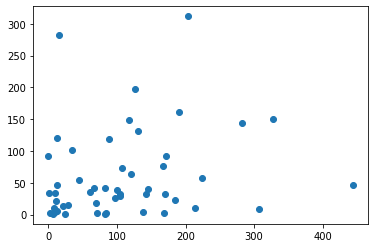

In [37]:
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
imp_stripped = df[["x", "y"]].to_numpy()
plt.scatter(imp_stripped[:,0], imp_stripped[:,1])

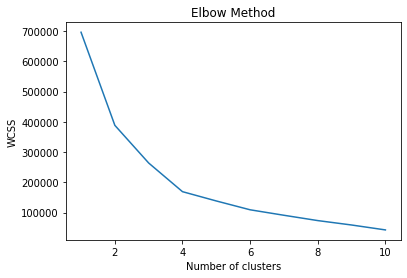

In [38]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(imp_stripped)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

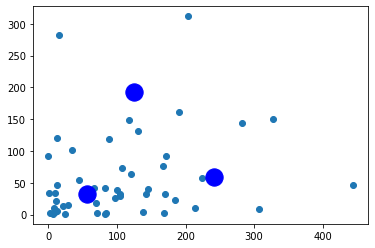

In [39]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(imp_stripped)
plt.scatter(imp_stripped[:,0], imp_stripped[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='blue')
plt.show()